<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Heatmap_each_RF_Seq_var3_Anneal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This program generates one heatmap for each landmark, while `Heatmap_all.ipynb` generates one heatmap for all landmarks.

* 不要用 Gaussian 做 Label，匹配 Loss Function 的形状，保证理论上误差为0.


# 1. Initialize

In [1]:
# function ConnectButton(){
#   console.log("Connect pushed"); 
#   document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }
# setInterval(ConnectButton,60000);


# clearInterval(37042)

In [2]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['Procruses Analysis.ipynb',
 'PCA.ipynb',
 '__pycache__',
 'utils',
 'datasets',
 'Gaussian.ipynb',
 'Heatmap_all.ipynb',
 'trained_models',
 'DataPreprocessing.ipynb',
 'checkpoints',
 'Heatmap_each.ipynb',
 'Update_leaf.ipynb']

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb
from torch.nn import Upsample
from torch.autograd import Variable
import torch.optim as optim
import time

import warnings
warnings.filterwarnings('ignore')


In [4]:
from utils.hourglass import *
from utils.dataloader import *

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dim_tree = 5 # how deep the regression tree is 
num_tree = 3 # number of regression trees
variance_gaussian = 3

num_fc = int(num_tree*(2**(dim_tree-1)-1))
num_leaf_nodes = int(num_tree*2**(dim_tree-1))

# 2. Data Loader

In [ ]:
helen_trainset = Helen_set(dataset_type="train",var=variance_gaussian)

Loading [1/2000] pictures......


KeyboardInterrupt: ignored

In [ ]:
helen_testset = Helen_set(dataset_type="test",var=variance_gaussian)

In [ ]:
train_dataloder = DataLoader(helen_trainset, batch_size=30)
test_dataloder = DataLoader(helen_testset, batch_size=30)

# 3. Pre Train

In [6]:
helen_sampleset = Helen_set(dataset_type="sample")
sample_dataloder = DataLoader(helen_sampleset, batch_size=20)

Loading [1/200] pictures......
Loading [100/200] pictures......
Loading [200/200] pictures......


In [7]:
critical = torch.nn.MSELoss()

nIters = 200
HGNet = HGNet().to(device)
optimizer = optim.SGD(HGNet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [8]:
loss_hist = torch.zeros(nIters)
loss_epoch = torch.zeros(10)

for iter in range(nIters):
  for i, (x,_,y) in enumerate(sample_dataloder):
    x = Variable(x,requires_grad=True).float().to(device)
    y = Variable(y).float().to(device)
    y_pred = HGNet.forward(x)
    loss = critical(y_pred, y)
    loss_epoch[i] = loss.item()

    if i == 9:
      loss_avg = torch.sum(loss_epoch)/10
      loss_hist[iter] = loss_avg
      if (iter+1)%10 == 0 or iter == 0:
        print('Iter [%d/%d] loss %.4f' %(iter+1, nIters, loss_avg))
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(torch.arange(nIters),loss_hist.detach().numpy())
plt.title("Training Loss")

Iter [1/200] loss 0.4973
Iter [10/200] loss 0.4149
Iter [20/200] loss 0.3557


KeyboardInterrupt: ignored

In [ ]:
# torch.save(HGNet.state_dict(), "/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt")

# 4. Tune Training

## 4.1 Functions

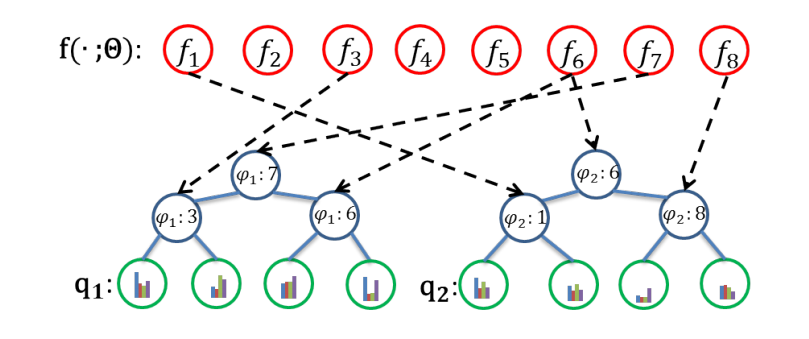

In [6]:
def leaf_direction(N):
  point = torch.zeros(2**N,N).to(device)

  def get01(number, len):
    result = torch.zeros(len).to(device)
    ind = len
    while ind >0:
      if 2**(ind-1)<=number:
        result[len-ind] = 1
        number -= 2**(ind-1)
      ind -= 1
    return result
  
  for i in range(2**N):
    point[i,:] = get01(i,N)

  return point.int()

In [7]:
def split_tree(up,here,which=0,mode='Second'):
  if mode=='initial':
    if which == 0:
      return here
    else: return (1-here)
  else:
    if which == 0:
      return up*here
    else: return up*(1-here)

In [8]:
def split_base(N):
  # returns index that split based on which cnn_fc col
  res = torch.zeros(2**N*N).to(device)
  lenth = 2**(N-1)
  num = 1
  left = 0
  repeat = 1
  max_repeat = 1
  while lenth>0 and repeat<2**N:
    res[left:left+lenth*2] = num
    left += lenth*2
    num += 1
    repeat -= 1
    if repeat == 0:
      lenth = int(lenth/2)
      repeat = max_repeat*2
      max_repeat = repeat
  return ((res.reshape(N,2**N)-1).T).int()

In [9]:
def phi(cnn_fc,mode='train'):
  N = cnn_fc.shape[0]
  out = torch.zeros(N,num_leaf_nodes).to(device)
  sigm = torch.zeros(cnn_fc.shape).to(device)

  if mode == 'test':
    sigm[cnn_fc>0] = 1
  else:
    sigm = torch.sigmoid(cnn_fc)

  direction = leaf_direction(dim_tree-1)
  tree_ind = split_base(dim_tree-1)
  X, Y = tree_ind.shape

  for ind_tree in range(num_tree):
    for x in range(X):
      for y in range(Y):
        here = sigm[:,ind_tree*(X-1)+tree_ind[x,y]]
        if y == 0:
          up = split_tree(torch.rand(3).to(device),here,which=direction[x,y],mode='initial')
        else:
          up = split_tree(up,here,which=direction[x,y])
        #print('y',y,'up',up)

      out[:,ind_tree*X+x] = up
    
  return out

In [10]:
def find_coord(prob_map):
  # prob_map(200,68*256*256)

  N = prob_map.shape[0]
  P = 12
  coord = torch.zeros(N,P*2).to(device)
  heatmap = prob_map.reshape(N,P,256,256).float()
  for n in range(N):
    for p in range(P):
      c1, c2 = torch.where(heatmap[n,p,:,:]==torch.max(heatmap[n,p,:,:]))
      coord[n,2*p], coord[n,2*p+1] = c1[0], c2[0]

  return coord

In [11]:
def get_mask(cnn_heatmaps,threshold=0.3):
  mask = torch.zeros(cnn_heatmaps.shape).to(device)
  B, P = cnn_heatmaps.shape[0:2]
  for b in range(B):
    for p in range(P):
      hm = cnn_heatmaps[b,p,:,:]
      mask[b,p,:,:][hm>torch.max(hm)*threshold]=1
  return mask

In [12]:
def update_iter(q, p, l):
  # q: leaf node
  # p: cnn probability
  # l: label

  gamma = torch.unsqueeze(p,2)*torch.unsqueeze(q,0) # (Ntrain,Nleaf,Nlabel)
  gamma = gamma/(torch.sum(gamma,axis=1,keepdims=True)+1e-8)
  score = torch.zeros(gamma.shape).to(q.device)
  for ll in range(q.shape[0]):
    score[:,ll,:] = l*gamma[:,ll,:]
  score = torch.sum(score,axis=0)+1e-8 # (3,2)

  return score/torch.sum(score,axis=1,keepdims=True)

In [13]:
def loss_ce(B, q, p, l):
  pred = torch.matmul(p,q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
  pred = pred/torch.sum(pred,axis=1,keepdims=True)
  l = l.reshape(B*12,-1)
  l = l/torch.sum(l,axis=1,keepdims=True)

  return -criterion_KL(pred,l)

def loss_l1(q, p, l):
  return torch.sum(torch.abs(torch.matmul(p,q)-l))/l.shape[0]

In [14]:
# def mask_and_norm(target, mask):
#   # target (B,12,256,256)
#   # mask (B,12,256,256)
#   B,P = target.shape[0:2]

#   res = (target*mask).reshape(B,P,-1)
#   res = res/torch.sum(res,axis=2,keepdims=True)
#   return res.reshape(B,-1)

## 4.2 Sample Set

In [15]:
helen_sampleset = Helen_set(dataset_type="sample",var=variance_gaussian)
sample_dataloder = DataLoader(helen_sampleset, batch_size=20)
helen_sampletest = Helen_set(dataset_type="sample_test",var=variance_gaussian)
sample_test_dataloder = DataLoader(helen_sampletest, batch_size=10)

Loading [1/200] pictures......
Loading [100/200] pictures......
Loading [200/200] pictures......
Loading [1/30] pictures......


## 4.3 Network

In [16]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet.load_state_dict(torch.load("/content/drive/My Drive/Face Alignment DRF/trained_models/Original_HGNet.pt"))

<All keys matched successfully>

In [17]:
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

## 4.4 Training

In [18]:
#######################
# Initialization
Total_train = 10

# CNN initilization
nIters = 1000

criterion_MSE = torch.nn.MSELoss()
criterion_KL = torch.nn.KLDivLoss()
optimizer = optim.SGD(Tune_HGNet.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Regression Tree parameters
rf_Iters = 60

### Training using L2 Loss

In [ ]:
# Using L2 Loss

for round in range(Total_train):
  print("###########################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)
  
  #####################################
  ### Train Hourglass
  ### eyes: [36:48]
  #####################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,12*256*256).to(device)/(256*256)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)
      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q).reshape(B,12,256,256)
      # get mask for computing cnn loss
      cnn_mask = get_mask(cnn_heatmaps,threshold=0.5)
      loss = criterion_MSE(cnn_heatmaps*cnn_mask, y[:,36:48,:,:]*cnn_mask)

      loss_epoch += loss.item()
      if (iter+1)%20 == 0 or iter == 0:
        if i == 9:
          print('     CNN training, Iter [%d/%d], loss_L2: %.8f' %(iter+1, cnn_Iters, loss_epoch*224*224*1e-1))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


  #####################################
  ### Train Regression Trees using pinv
  #####################################
  with torch.no_grad():
    leaf_q_new = torch.zeros(num_leaf_nodes,12*256*256).to(device)
    loss0 = 0

    for i, (x,coord,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)
      cnn_prob = phi(outputs)

      pred_coord0 = find_coord(torch.matmul(cnn_prob,leaf_q))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))

      leaf_q_new += torch.matmul(torch.linalg.pinv(cnn_prob), y_expand) #(8,12*256*256)

    leaf_q = leaf_q_new/10  # average among each bach
    leaf_q = torch.abs(leaf_q.reshape(num_leaf_nodes,12,-1)) #(B,12,256*256)
    leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    for nleaf in range(num_leaf_nodes):
      for npoints in range(12):
        leaf_q[nleaf,npoints,:][leaf_q[nleaf,npoints,:] <= torch.max(leaf_q[nleaf,npoints,:])*0.2] = 0
    leaf_q = leaf_q/torch.sum(leaf_q, axis=2, keepdims=True)
    leaf_q = leaf_q.reshape(num_leaf_nodes,-1)

    print("     RF training, coordinate loss: %.4f" %(loss0/10))





### Training using Log likelihood

############################################################################
Round 1, Using GPU
     CNN training, Iter [1/30], loss_KL: 3.8547692
     -----> CNN training time: ## 2.69 mins ## 


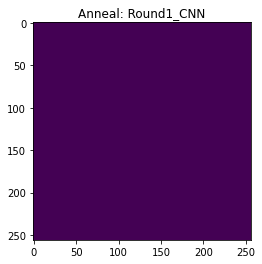

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8579
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8582
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8582
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8582
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8582
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8573
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8576
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8577
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8577
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8573
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8577
     RF training, coordinate loss: 2731.8271


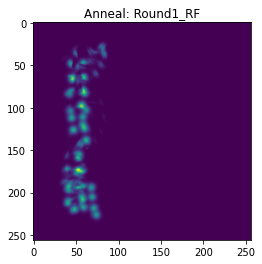

     -----> RF training time: ## 9.91 mins ## 
     -----> Training time for this round: ## 12.60 mins ## 
############################################################################
Round 2, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8549254
     CNN training, Iter [50/1000], loss_KL: 3.8549248
     CNN training, Iter [100/1000], loss_KL: 3.8549244
     CNN training, Iter [150/1000], loss_KL: 3.8549239
     CNN training, Iter [200/1000], loss_KL: 3.8549234
     CNN training, Iter [250/1000], loss_KL: 3.8549229
     CNN training, Iter [300/1000], loss_KL: 3.8549225
     CNN training, Iter [350/1000], loss_KL: 3.8549220
     CNN training, Iter [400/1000], loss_KL: 3.8549215
     CNN training, Iter [450/1000], loss_KL: 3.8549211
     CNN training, Iter [500/1000], loss_KL: 3.8549207
     CNN training, Iter [550/1000], loss_KL: 3.8549202
     CNN training, Iter [600/1000], loss_KL: 3.8549199
     CNN training, Iter [650/1000], loss_KL: 3.8549194
     CNN training, Iter [700/1

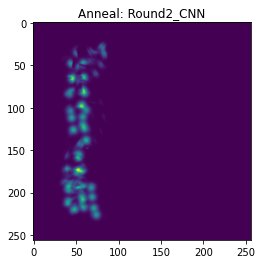

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8576
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8582
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8582
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8582
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8582
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8573
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8576
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8577
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8577
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8573
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8577
     RF training, coordinate loss: 2843.6594


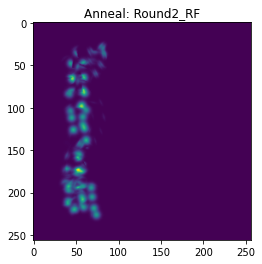

     -----> RF training time: ## 9.88 mins ## 
     -----> Training time for this round: ## 99.22 mins ## 
############################################################################
Round 3, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8549230
     CNN training, Iter [50/1000], loss_KL: 3.8549226
     CNN training, Iter [100/1000], loss_KL: 3.8549221
     CNN training, Iter [150/1000], loss_KL: 3.8549217
     CNN training, Iter [200/1000], loss_KL: 3.8549213
     CNN training, Iter [250/1000], loss_KL: 3.8549208
     CNN training, Iter [300/1000], loss_KL: 3.8549204
     CNN training, Iter [350/1000], loss_KL: 3.8549199
     CNN training, Iter [400/1000], loss_KL: 3.8549196
     CNN training, Iter [450/1000], loss_KL: 3.8549191
     CNN training, Iter [500/1000], loss_KL: 3.8549187
     CNN training, Iter [550/1000], loss_KL: 3.8549184
     CNN training, Iter [600/1000], loss_KL: 3.8549178
     CNN training, Iter [650/1000], loss_KL: 3.8549175
     CNN training, Iter [700/1

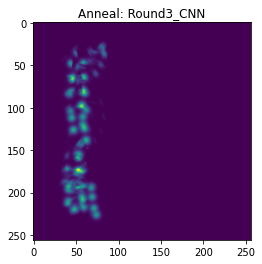

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8575
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8580
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8581
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8581
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8581
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8573
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8576
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8577
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8577
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8573
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8578
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8578
     RF training, coordinate loss: 2901.8965


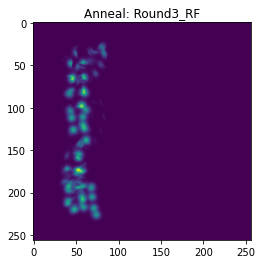

     -----> RF training time: ## 9.84 mins ## 
     -----> Training time for this round: ## 99.11 mins ## 
############################################################################
Round 4, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8549201
     CNN training, Iter [50/1000], loss_KL: 3.8549197
     CNN training, Iter [100/1000], loss_KL: 3.8549193
     CNN training, Iter [150/1000], loss_KL: 3.8549187
     CNN training, Iter [200/1000], loss_KL: 3.8549184
     CNN training, Iter [250/1000], loss_KL: 3.8549180
     CNN training, Iter [300/1000], loss_KL: 3.8549176
     CNN training, Iter [350/1000], loss_KL: 3.8549171
     CNN training, Iter [400/1000], loss_KL: 3.8549166
     CNN training, Iter [450/1000], loss_KL: 3.8549162
     CNN training, Iter [500/1000], loss_KL: 3.8549160
     CNN training, Iter [550/1000], loss_KL: 3.8549154
     CNN training, Iter [600/1000], loss_KL: 3.8549150
     CNN training, Iter [650/1000], loss_KL: 3.8549147
     CNN training, Iter [700/1

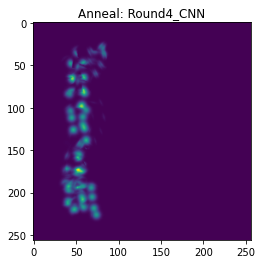

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8574
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8580
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8581
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8581
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8581
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8573
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8576
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8577
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8577
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8573
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8578
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8578
     RF training, coordinate loss: 2790.1372


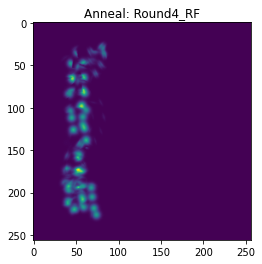

     -----> RF training time: ## 9.89 mins ## 
     -----> Training time for this round: ## 99.44 mins ## 
############################################################################
Round 5, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8549168
     CNN training, Iter [50/1000], loss_KL: 3.8549162
     CNN training, Iter [100/1000], loss_KL: 3.8549158
     CNN training, Iter [150/1000], loss_KL: 3.8549154
     CNN training, Iter [200/1000], loss_KL: 3.8549150
     CNN training, Iter [250/1000], loss_KL: 3.8549147
     CNN training, Iter [300/1000], loss_KL: 3.8549142
     CNN training, Iter [350/1000], loss_KL: 3.8549139
     CNN training, Iter [400/1000], loss_KL: 3.8549135
     CNN training, Iter [450/1000], loss_KL: 3.8549132
     CNN training, Iter [500/1000], loss_KL: 3.8549128
     CNN training, Iter [550/1000], loss_KL: 3.8549124
     CNN training, Iter [600/1000], loss_KL: 3.8549121
     CNN training, Iter [650/1000], loss_KL: 3.8549115
     CNN training, Iter [700/1

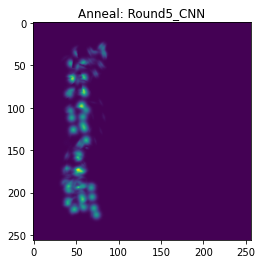

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8574
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8580
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8581
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8581
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8581
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8573
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8576
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8576
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8576
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8576
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8573
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8578
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8578
     RF training, coordinate loss: 2599.9204


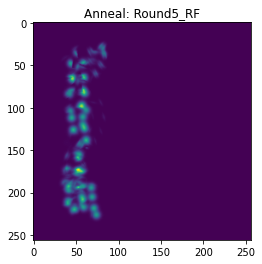

     -----> RF training time: ## 9.88 mins ## 
     -----> Training time for this round: ## 98.76 mins ## 
############################################################################
Round 6, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8549130
     CNN training, Iter [50/1000], loss_KL: 3.8549126
     CNN training, Iter [100/1000], loss_KL: 3.8549122
     CNN training, Iter [150/1000], loss_KL: 3.8549119
     CNN training, Iter [200/1000], loss_KL: 3.8549114
     CNN training, Iter [250/1000], loss_KL: 3.8549110
     CNN training, Iter [300/1000], loss_KL: 3.8549107
     CNN training, Iter [350/1000], loss_KL: 3.8549103
     CNN training, Iter [400/1000], loss_KL: 3.8549100
     CNN training, Iter [450/1000], loss_KL: 3.8549099
     CNN training, Iter [500/1000], loss_KL: 3.8549095
     CNN training, Iter [550/1000], loss_KL: 3.8549092
     CNN training, Iter [600/1000], loss_KL: 3.8549088
     CNN training, Iter [650/1000], loss_KL: 3.8549084
     CNN training, Iter [700/1

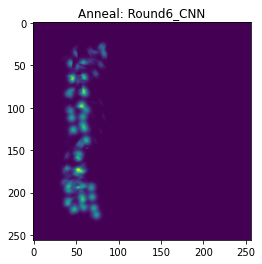

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8574
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8580
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8581
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8581
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8581
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8572
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8576
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8576
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8576
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8576
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8573
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8578
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8578
     RF training, coordinate loss: 2560.0981


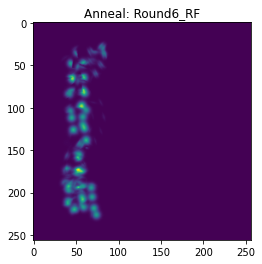

     -----> RF training time: ## 9.88 mins ## 
     -----> Training time for this round: ## 98.66 mins ## 
############################################################################
Round 7, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8549093
     CNN training, Iter [50/1000], loss_KL: 3.8549089
     CNN training, Iter [100/1000], loss_KL: 3.8549086
     CNN training, Iter [150/1000], loss_KL: 3.8549084
     CNN training, Iter [200/1000], loss_KL: 3.8549079
     CNN training, Iter [250/1000], loss_KL: 3.8549076
     CNN training, Iter [300/1000], loss_KL: 3.8549073
     CNN training, Iter [350/1000], loss_KL: 3.8549070
     CNN training, Iter [400/1000], loss_KL: 3.8549067
     CNN training, Iter [450/1000], loss_KL: 3.8549063
     CNN training, Iter [500/1000], loss_KL: 3.8549060
     CNN training, Iter [550/1000], loss_KL: 3.8549057
     CNN training, Iter [600/1000], loss_KL: 3.8549054
     CNN training, Iter [650/1000], loss_KL: 3.8549052
     CNN training, Iter [700/1

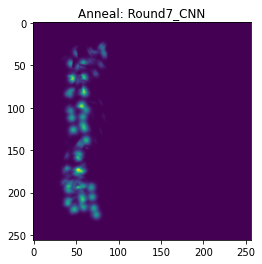

     RF training, Batch 1, rf_iter [1/60], loss_KL: 3.8574
     RF training, Batch 1, rf_iter [15/60], loss_KL: 3.8580
     RF training, Batch 1, rf_iter [30/60], loss_KL: 3.8581
     RF training, Batch 1, rf_iter [45/60], loss_KL: 3.8581
     RF training, Batch 1, rf_iter [60/60], loss_KL: 3.8581
     RF training, Batch 4, rf_iter [1/60], loss_KL: 3.8571
     RF training, Batch 4, rf_iter [15/60], loss_KL: 3.8575
     RF training, Batch 4, rf_iter [30/60], loss_KL: 3.8575
     RF training, Batch 4, rf_iter [45/60], loss_KL: 3.8575
     RF training, Batch 4, rf_iter [60/60], loss_KL: 3.8575
     RF training, Batch 8, rf_iter [1/60], loss_KL: 3.8573
     RF training, Batch 8, rf_iter [15/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [30/60], loss_KL: 3.8577
     RF training, Batch 8, rf_iter [45/60], loss_KL: 3.8578
     RF training, Batch 8, rf_iter [60/60], loss_KL: 3.8578
     RF training, coordinate loss: 2748.6111


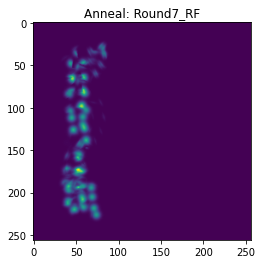

     -----> RF training time: ## 9.88 mins ## 
     -----> Training time for this round: ## 98.70 mins ## 
############################################################################
Round 8, Using GPU
     CNN training, Iter [1/1000], loss_KL: 3.8549056
     CNN training, Iter [50/1000], loss_KL: 3.8549054
     CNN training, Iter [100/1000], loss_KL: 3.8549051


In [ ]:
# update using log likelihood

time_initial = time.time()
for round in range(Total_train):
  time_start = time.time()
  print("############################################################################")
  if torch.cuda.is_available():
    print("Round %d, Using GPU" %(round+1))
  else:
    print("Round ", round+1)

  
  ######################################################
  ### Train Hourglass
  ### eyes: [36:48]
  ######################################################
  if round == 0:
    leaf_q = torch.ones(num_leaf_nodes,12,256*256).to(device)/(256*256)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)*(round*0.2+1)
      cnn_prob = phi(outputs)

      cnn_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
      cnn_heatmaps = cnn_heatmaps/torch.sum(cnn_heatmaps,axis=1,keepdims=True)
      label_heatmaps = y[:,36:48,:,:].reshape(B*12,-1)
      label_heatmaps = label_heatmaps/torch.sum(label_heatmaps,axis=1,keepdims=True)
      loss = -criterion_KL(cnn_heatmaps,label_heatmaps)

      loss_epoch += loss.item()
      if (iter+1)%50 == 0 or iter == 0:
        if i == 9:
          print('     CNN training, Iter [%d/%d], loss_KL: %.7f' %(iter+1, cnn_Iters, loss_epoch*224*224*1e-1))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # calculate time for CNN training
  time_cnn = time.time()
  print("     -----> CNN training time: ## %.2f mins ## " %((time_cnn-time_start)/60))

  # plot the face after CNN training
  cnn_prob_test = phi(outputs, mode='test')
  cnn_heatmaps = torch.matmul(cnn_prob_test,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,12,-1)
  first_face = torch.sum(cnn_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_CNN")
  plt.savefig(os.path.join("checkpoints/Anneal_RF_Seq/var_"+str(variance_gaussian),"Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_CNN.png"))
  plt.show()

  ######################################################
  ### Train Regression Trees using variational bounding
  ######################################################
  with torch.no_grad():
    loss0 = 0

    leaf_q = leaf_q.reshape(num_leaf_nodes,12,256*256)
    for i, (x,coord,y) in enumerate(sample_dataloder):
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y[:,36:48,:,:].reshape(B,12,-1) #(200,12*256*256)

      outputs = Tune_HGNet.forward(x)*(round*0.2+1)
      cnn_prob = phi(outputs, mode='test')

  
      for rf_iter in range(rf_Iters):
        for points_id in range(12):
          leaf_q[:,points_id,:] = update_iter(leaf_q[:,points_id,:], cnn_prob, y_expand[:,points_id,:])
        if ((i+1)%4 == 0 or i == 0) and ((rf_iter+1)%15 == 0 or rf_iter == 0):
          rf_loss_CE = loss_ce(B, leaf_q, cnn_prob, y_expand)
          print("     RF training, Batch %d, rf_iter [%d/%d], loss_KL: %.4f" %(i+1, rf_iter+1, rf_Iters, rf_loss_CE*224*224))

      # cnn_prob_test = phi(outputs, mode='test')
      pred_coord0 = find_coord(torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)))
      loss0 += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))

    print("     RF training, coordinate loss: %.4f" %(loss0/10))


  # plot the face after rf training
  rf_heatmaps = torch.matmul(cnn_prob,leaf_q.reshape(num_leaf_nodes,-1)).reshape(B,12,-1)
  first_face = torch.sum(rf_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_RF")
  plt.savefig(os.path.join("checkpoints/Anneal_RF_Seq/var_"+str(variance_gaussian),"Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+"_RF.png"))
  plt.show()

  # save parameters for this round
  torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/Anneal_RF_Seq/var_"+str(variance_gaussian),"Tune_HGNet_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+'.pt'))
  torch.save(leaf_q, os.path.join("checkpoints/Anneal_RF_Seq/var_"+str(variance_gaussian),"leaf_q_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round"+str(round+1)+'.pt'))

  # calculate time for rf training
  time_rf = time.time()
  print("     -----> RF training time: ## %.2f mins ## " %((time_rf-time_cnn)/60))
  print("     -----> Training time for this round: ## %.2f mins ## " %((time_rf-time_start)/60))

# Finish Training
torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/Anneal_RF_Seq/var_"+str(variance_gaussian),"Tune_HGNet_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))
torch.save(leaf_q, os.path.join("checkpoints/Anneal_RF_Seq/var_"+str(variance_gaussian),"leaf_q_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))

# calculate total training time
time_end = time.time()
print("-----> Total training time: ## %.2f hrs ## " %((time_end-time_initial)/3600))

## 4.5 Test

### Restore from saved weights

In [ ]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

Tune_HGNet.load_state_dict(torch.load(os.path.join("checkpoints/var_"+str(variance_gaussian),"Tune_HGNet_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt")))
leaf_q = torch.load(os.path.join("checkpoints/var_"+str(variance_gaussian),"leaf_q_Loss_KL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_final.pt"))

In [ ]:
import torchsummary
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
torchsummary.summary(Tune_HGNet, (3,256,256))
print('parameters_count:',count_parameters(Tune_HGNet))

### Test

In [ ]:
heatmap_loss, coord_loss = 0, 0
Tune_HGNet.eval()
criterion = torch.nn.MSELoss()

for i, (img,coord,hm) in enumerate(sample_test_dataloder):
  img = img.float().to(device)
  img.requires_grad = True
  coord = coord.float().to(device)
  hm = hm.float().to(device)
  B = img.shape[0]
  
  outputs = Tune_HGNet.forward(img)
  pred_heatmaps = torch.matmul(phi(outputs,mode='test'),leaf_q.reshape(num_leaf_nodes,-1)) #(15,12*256*256)
  pred_coords = find_coord(pred_heatmaps) #(15,12*2)

  heatmap_loss += criterion(pred_heatmaps, hm[:,36:48,:,:].reshape(B,-1))
  coord_loss += torch.sum(torch.abs(pred_coords-coord[:,36:48,:].reshape(B,-1)))

print("Heatmap loss %.8f, Coord loss %.4f" %(heatmap_loss/10, coord_loss/10))

In [ ]:
phi(outputs)[0:5,:]

In [ ]:
for ith in range(8):
  x = pred_coords[ith,::2].detach().cpu()
  y = pred_coords[ith,1::2].detach().cpu()
  plt.scatter(x,256-y,label="Prediction %d" %ith)

  plt.legend(loc='lower left')
  plt.xlim(0,256)
  plt.ylim(0,256)

In [ ]:
ith = 0

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 1

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 2

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 3

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 4

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 5

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 6

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
ith = 7

x = pred_coords[ith,::2].detach().cpu()
y = pred_coords[ith,1::2].detach().cpu()
plt.scatter(x,256-y,label="Prediction")

x2 = coord[ith,36:48,0].detach().cpu()
y2 = coord[ith,36:48,1].detach().cpu()
plt.scatter(x2,256-y2,label="GT")

plt.legend(loc='lower left')
plt.xlim(0,256)
plt.ylim(0,256)

In [ ]:
plot_heatmaps = pred_heatmaps.reshape(B,12,256,256).detach().cpu()
plot_heatmaps_all = torch.sum(plot_heatmaps,axis=1)
plt.imshow(plot_heatmaps_all[ith,:,:])

In [ ]:
# one point
plt.imshow(plot_heatmaps[ith,0,:,:])

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[0,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[1,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[2,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[3,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[4,0,:,:].detach().cpu())

In [ ]:
plt.imshow(leaf_q.reshape(num_leaf_nodes,12,256,256)[5,0,:,:].detach().cpu())

In [ ]:
image = torch.sum(hm, axis=1).detach().cpu()
plt.imshow(image[ith,:,:])

In [ ]:
plt.imshow(img[ith,:,:,:].detach().cpu().permute(1,2,0).int())